In [2]:
import pandas as pd
%matplotlib inline
import matplotlib as plt
pd.set_option("display.max_columns",999)
import numpy as np
import json
import datetime

# Getting some info from JSON file

In [3]:
df = pd.read_pickle("../pickles/cuentalo_clean_1.pkl")

In [78]:
# filter old cited tweets 
#df=df[df['created_at']>=datetime.datetime(2018,4,27)]
extra_tweets = set()
with open("../data/tweets_faltantes.csv") as fi:
    for line in fi:
        extra_tweets.add(int(line.strip()))
with open("../data/tweets_faltantes_2.csv") as fi:
    for line in fi:
        extra_tweets.add(int(line.strip()))
df = df[~df.id.isin(extra_tweets)]

In [89]:
len(df)

2124139

In [82]:
set(df.id.values).intersection(extra_tweets)

set()

### How many tweets per 5 minutes?

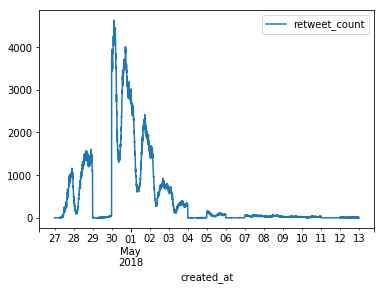

In [83]:
df[['created_at','retweet_count']][df['created_at']>=datetime.datetime(2018,4,27)].set_index('created_at').resample('5T').count().plot()

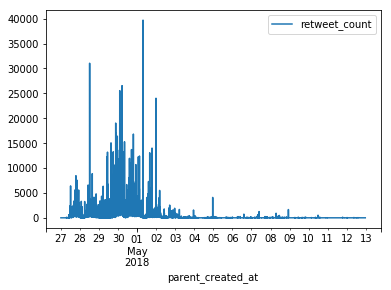

In [84]:
df[['parent_created_at','retweet_count']][df['parent_created_at']>=datetime.datetime(2018,4,27)].set_index('parent_created_at').resample('5T').count().plot()

There are two days missing ? 29/4 and 4/5, reconstructed by the references to them from older tweets

Roughly a peak of 5K tweets is a lot. We could try a smaller time window but then horizontally we'll get too many points. (2 weeks at 5 min are 4032 points, every 2 minutes we have 10080)


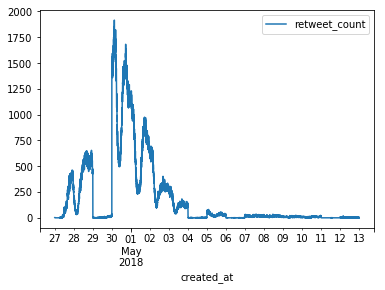

In [85]:
df[['created_at','retweet_count']][df['created_at']>=datetime.datetime(2018,4,27)].set_index('created_at').resample('2T').count().plot()

### Analizing the nature of RTs

In [86]:
# cuantos tipos de tweets hay?
df.groupby('tweet_type')['id'].count()

tweet_type
original     119043
quote          8631
reply         23262
retweet     1973203
Name: id, dtype: int64

In [87]:
# how do we check if the RT count is the same for each new RT?
grouped_originals=df[(df.tweet_type!="retweet") &(df['created_at']>=datetime.datetime(2018,4,27))]
grouped_retweets=df[(df.tweet_type=="retweet") &(df['created_at']>=datetime.datetime(2018,4,27))].groupby('parent_id')

In [88]:
# tenemos todo?
print('tweets originales',len(grouped_originals))
parent_ids=set(grouped_retweets['parent_retweet_count'].max().index)
print('tweets mencionados',len(parent_ids))
print('tweets mencionados que no están:',len(parent_ids.difference(set(grouped_originals.index))))

tweets originales 150450
tweets mencionados 62098
tweets mencionados que no están: 4867


In [77]:

pd.DataFrame(grouped_retweets['parent_retweet_count'].max().sort_values(ascending=False))
grouped_originals[grouped_originals.id.isin(df.parent_id.unique())][['retweet_count','user_screen_name','created_at']].sort_values('retweet_count',ascending=False)





,retweet_count,user_screen_name,created_at
990201907456208896,54705,martolius,2018-04-28 12:11:46
991217730601848834,44150,micaserrano23,2018-05-01 07:28:17
991464409825505280,33892,viickymonti,2018-05-01 23:48:30
990818114995703808,22633,rg_vianca,2018-04-30 05:00:21
990775116807229440,20483,sabri_barra,2018-04-30 02:09:30
991793329464598500,19888,emilecalvet,2018-05-02 21:35:31
990698320015261700,18835,orneeokk,2018-04-29 21:04:20
990779462273953794,17764,cchaconj,2018-04-30 02:26:46
990325049893801984,17472,AlejandraTuk,2018-04-28 20:21:05
991034153268383751,17195,santygom3z,2018-04-30 19:18:49


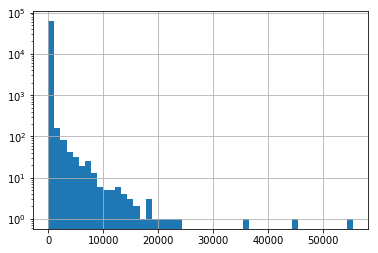

In [62]:
# How many retweets per tweet?
grouped_retweets['retweet_count'].max().hist(bins=50).set_yscale('log')

In [74]:
grouped_originals['retweet_count'].sort_values(ascending=False).astype(int).head(30) 

989761714794082300    154684
989893214378299400    107535
991597524841529300     97167
990290642956767200     93280
990201907456208896     54705
991217730601848834     44150
991295693041164300     41837
954346967722790900     40805
720351638167371800     39466
979849400792035300     37046
991366980153339900     34083
991464409825505280     33892
989520253930627100     31788
991493795324801000     26523
990918434119614500     26136
989520601713926100     24993
981884790562525200     24684
989656034045251600     24664
990834479274102800     24391
991155060091576300     24368
990542133802274800     23606
990818114995703808     22633
991471676444594200     22514
990648680632926200     21749
990534847604064300     21218
990775116807229440     20483
991793329464598500     19888
989508161727057900     19460
990698320015261700     18835
972165514595373000     18200
Name: retweet_count, dtype: int64

In [73]:
grouped_retweets['retweet_count'].std()

parent_id
646602982713360384         NaN
747883568735600640         NaN
989554972697251845    0.100248
989604040525910017    0.000000
989759402767859712    0.000000
989759705344950273    0.000000
989762675411378177    0.000000
989764018779840518         NaN
989764409403756544    0.000000
989764518556319744         NaN
989765213242052608    0.000000
989766305610743811    0.000000
989771586658910210    0.000000
989772601244319744         NaN
989776339719860224    0.000000
989782227167870976    0.000000
989782715812732929    0.000000
989784076700831744    0.000000
989784142069067776    0.000000
989785353975402496    0.000000
989789562183585793    0.000000
989791538019434496         NaN
989800961903349760    0.000000
989801094783078401    0.000000
989801189360455681    0.000000
989801251578744833    0.000000
989801496026939393    0.000000
989801589853577216    0.164349
989801881802280961    0.000000
989801983069577217    0.000000
                        ...   
995317677693419520    0.00000

In [25]:
# hay tweet Ids que cambian el numero de RTs, los que no cambian 
(len(grouped_retweets['retweet_count'].std()[grouped_retweets['retweet_count'].std()>0]),
len(grouped_retweets['retweet_count'].std()[grouped_retweets['retweet_count'].std()==0]))

(0, 0)

In [21]:
grouped_retweets['retweet_count'].std()[grouped_retweets['retweet_count'].std()>0].head()

parent_id
989554972697251845    0.100248
989801589853577216    0.164349
989807397865771008    0.106600
989811233984573441    0.224529
989828567285592066    0.079305
Name: retweet_count, dtype: float64

In [22]:
### Vamos a clasificar los tweets que cambian o no sus RTs para observarlos
grouped_retweets.retweet_count.std().dropna().sort_values(ascending=False).head(10)

parent_id
991464409825505280    700.623534
994495599788556289    579.534600
990896349544579072    529.570540
991818513395408896    499.717871
991784392900083712    323.333529
991907915463262208    323.009336
992177026294583296    293.017860
992541961390317569    277.901188
989948689908191232    277.512085
991788720239075328    261.947767
Name: retweet_count, dtype: float64

In [23]:
# armamos una columna para cada id unico y vemos si cambia su numero de RT
RTs_with_changing_rts=pd.DataFrame(grouped_retweets['retweet_count'].std()>0)
RTs_with_changing_rts.columns=["variance_of_RT_count"]

In [24]:
# ponemos la columna en la df de retweets
retweets=retweets.merge(RTs_with_changing_rts,how="left",left_on='parent_id',right_index=True)

In [25]:
# chequeamos--tenemos el mismo numero de tweets unicos
len(retweets[retweets.variance_of_RT_count].parent_id.unique())

2821

In [9]:
# y estos 2821 tweets son RT casi 1.6M de veces
len(retweets[retweets.variance_of_RT_count])

1599673

In [10]:
# identifiquemos algunos
unidx=RTs_with_changing_rts.index[0]
retweets[retweets.parent_id==unidx][['created_at','retweet_count']]

,created_at,retweet_count
990202654226878464,2018-04-28 12:14:44,4
990200514720796672,2018-04-28 12:06:14,4
989903647474581505,2018-04-27 16:26:35,4
989825564302290944,2018-04-27 11:16:19,4


In [37]:
retweets[retweets.parent_id==991464409825505280][['created_at','retweet_count']]

,created_at,retweet_count
992192068926746624,2018-05-03 23:59:57,33117
992192064346615808,2018-05-03 23:59:56,33117
992192045824475137,2018-05-03 23:59:52,33117
992192045547745280,2018-05-03 23:59:52,33117
992192043786100736,2018-05-03 23:59:51,33117
992192041357541376,2018-05-03 23:59:51,33117
992191986898628616,2018-05-03 23:59:38,33117
992191923036319744,2018-05-03 23:59:23,33117
992191907198418944,2018-05-03 23:59:19,33117
992191851762475008,2018-05-03 23:59:06,33117


In [11]:
# check por si hay nans
retweets[np.isnan(retweets.retweet_count)]

,country,created_at,favorite_count,full_text,id,lat,location,lon,parent_country,parent_created_at,parent_id,parent_lat,parent_location,parent_lon,parent_place,parent_text,parent_time_zone,parent_user_followers,parent_user_id,place,quote_count,retweet_count,statuses_count,time_zone,tweet_type,user_followers_count,user_id,user_screen_name,variance_of_RT_count


**CONCLUSION los RTcount cambian un poco pero parece un artefacto, son muy pocos y puedo tomar o el mayor numero o el mas reciente y estará OK**

Historias de un tweet:
* Original
* Original->Retweet
* Original->Quote
* Original->Reply
* Quote->Retweet
* Quote->Quote
* Quote->Reply
* Reply->Retweet
* Reply->Quote
* Reply->Reply

In [18]:
# Ahora podemos mirar en detalle los tweets originales+quotes+replies vs los retweets.
# Estan todos?
retweeted_ids_with_maxcounts=grouped_retweets['retweet_count'].max()
retweeted_ids_with_maxcounts.head()

parent_id
646602982713360384    118
747883568735600640     12
989554972697251845    323
989604040525910017      7
989759402767859712     32
Name: retweet_count, dtype: int32

In [13]:
originals=df[df['tweet_type']=='original']
quotes=df[df['tweet_type']=='quote']
replies=df[df['tweet_type']=='reply']
# ya tengo retweets

In [14]:
historias_resumen={}

In [15]:
# tweets originales
original_ids=set(originals.id.values)
original_replied=len(original_ids.intersection(set(replies.parent_id.values)))
original_quoted=len(original_ids.intersection(set(quotes.parent_id.values)))
original_retweeted=len(original_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["originales"]={"total":len(original_ids), 
                         "respondidos":original_replied, 
                         "citados": original_quoted, 
                         "retweeted": original_retweeted}

In [16]:
# tweets respuestas
reply_ids=set(replies.id.values)
reply_replied=len(reply_ids.intersection(set(replies.parent_id.values)))
reply_quoted=len(reply_ids.intersection(set(quotes.parent_id.values)))
reply_retweeted=len(reply_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["respuestas"]={"total":len(reply_ids), 
                         "respondidos":reply_replied, 
                         "citados": reply_quoted, 
                         "retweeted": reply_retweeted}

In [17]:
# tweets quotes
quote_ids=set(quotes.id.values)
quote_replied=len(quote_ids.intersection(set(replies.parent_id.values)))
quote_quoted=len(quote_ids.intersection(set(quotes.parent_id.values)))
quote_retweeted=len(quote_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["citas"]={"total":len(quote_ids), 
                         "respondidos":quote_replied, 
                         "citados": quote_quoted, 
                         "retweeted": quote_retweeted}

In [18]:
# retweets 
retweet_ids=set(retweets.id.values)
retweet_replied=len(retweet_ids.intersection(set(replies.parent_id.values)))
retweet_quoted=len(retweet_ids.intersection(set(quotes.parent_id.values)))
retweet_retweeted=len(retweet_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["retweets"]={"total":len(retweet_ids), 
                         "respondidos":retweet_replied, 
                         "citados": retweet_quoted, 
                         "retweeted": retweet_retweeted}

## Este es el resultado de esta seccion

In [20]:
pd.DataFrame(historias_resumen).transpose()

,citados,respondidos,retweeted,total
originales,1725,4885,48178,111337
respuestas,113,6375,6234,19374
citas,62,114,2819,8084
retweets,0,0,0,1973203


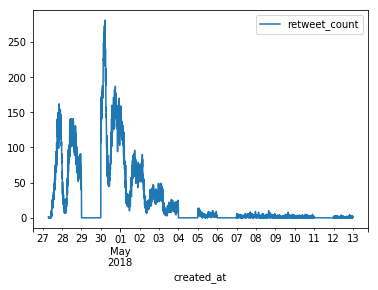

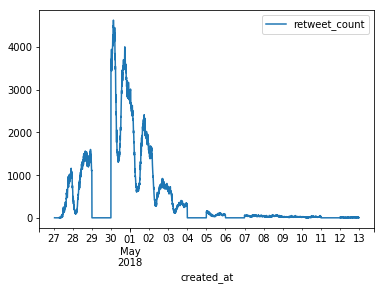

In [22]:
originals[['created_at','retweet_count']].set_index('created_at').resample('5T').count().plot()
df[['created_at','retweet_count']].set_index('created_at').resample('5T').count().plot()

In [47]:
with_content_ids_set=set(list(originals.id.values)+list(quotes.id.values)+list(replies.id.values))
print ("Tweets con contenido: ",len(with_content_ids_set))
print ("De los que retweeteados: ",len(with_content_ids_set.intersection(set(retweets.parent_id.values))))
print ("Me faltarian ",len(set(list(retweets.parent_id.values)+list(replies.parent_id.values)+list(quotes.parent_id.values)).difference(with_content_ids_set))," tweets con contenido")
print ("Ademas, en la DB se mencionan ",len(df.parent_id.unique())," tweets que suman ",df[df.parent_id>0].groupby('parent_id')['retweet_count'].max().sum()," retweets")

Tweets con contenido:  138795
De los que retweeteados:  57231
Me faltarian  14057  tweets con contenido
Ademas, en la DB se mencionan  77735  tweets que suman  2787585  retweets


Los que faltan serán los de los dos días que faltan???

In [48]:
originals.head()

,country,created_at,favorite_count,full_text,id,lat,location,lon,parent_country,parent_created_at,parent_id,parent_lat,parent_location,parent_lon,parent_place,parent_text,parent_time_zone,parent_user_followers,parent_user_id,place,quote_count,retweet_count,statuses_count,time_zone,tweet_type,user_followers_count,user_id,user_screen_name
990380122082611200,None,2018-04-28 23:59:56,1,17 años.Vuelvo a casa con miedo. Se me acerca ...,990380122082611200,-999.0,,-999.0,None,NaT,0,None,None,None,None,None,None,-1,0,None,-1,0,3126,Hawaii,original,78,410012730,Angelasantos002
990380024703447040,None,2018-04-28 23:59:32,1,#Cuéntalo como hacéis las lentejas?,990380024703447040,-999.0,Cocretas del Bar,-999.0,None,NaT,0,None,None,None,None,None,None,-1,0,None,-1,0,8478,None,original,223,765926604400910337,capitancocreta
990380009549434882,None,2018-04-28 23:59:29,0,un grupo de amigas nos reunimos y salio la pla...,990380009549434882,-999.0,in they heart,-999.0,None,NaT,0,None,None,None,None,None,None,-1,0,None,-1,0,13079,Central Time (US & Canada),original,1196,2335901545,lapijadezayn_
990380001202761728,None,2018-04-28 23:59:27,5,Volvía a casa de la universidad. En el autobús...,990380001202761728,-999.0,MADRID,-999.0,None,NaT,0,None,None,None,None,None,None,-1,0,None,-1,3,6831,Athens,original,309,396794973,MariaRodas7
990379986564669441,None,2018-04-28 23:59:23,0,"Ninguna situación, por más pequeña que sea deb...",990379986564669441,-999.0,Friendzone,-999.0,None,NaT,0,None,None,None,None,None,None,-1,0,None,-1,0,293,None,original,15,838779702445805568,RainbowCloudBW


In [49]:
# What's the average number of RT per retweeted tweet?
retweeted_ids_with_maxcounts.mean()

44.45566684917389

In [50]:
# What's the variance?
retweeted_ids_with_maxcounts.std()

568.9743774456562

In [51]:
from scipy.stats import poisson
from scipy.special import factorial
import numpy as np
from scipy.optimize import curve_fit

In [52]:
cutoff=100

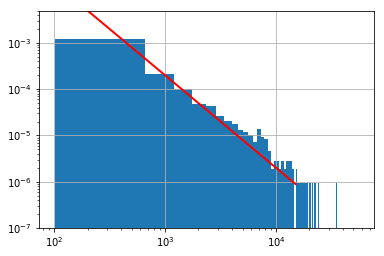

In [53]:
# Let's see the distribution of retweet counts...
x_end = 15000
fig, ax = plt.pyplot.subplots()
hist=retweeted_ids_with_maxcounts[retweeted_ids_with_maxcounts>cutoff].hist(bins=100,density=True)
x_plot = np.linspace(cutoff, x_end, 1000)
def wonk(vec,lam):
    return np.power(vec,-lam)*200 
plt.pyplot.plot(x_plot, wonk(x_plot, 2), 'r-', lw=2)  #### Roughly Power 2???
ax.set_yscale('log')
ax.set_xscale('log')
plt.pyplot.ylim((1e-7,5e-3))
plt.pyplot.show()

In [69]:
retweeted_ids_with_maxcounts[retweeted_ids_with_maxcounts>20000]

parent_id
990201907456208896    55482
990534847604064256    21568
990542133802274816    23924
990775116807229440    20485
990818114995703808    22676
991217730601848834    44786
991464409825505280    35531
Name: retweet_count, dtype: int32

In [81]:
tw=df[df.id.isin(retweeted_ids_with_maxcounts[retweeted_ids_with_maxcounts>10000].index)]
tw[['user_followers_count','retweet_count']].sort_values('retweet_count',ascending=False)

,user_followers_count,retweet_count
990201907456208896,1148,54705
991217730601848834,2543,44150
991464409825505280,2238,33892
990818114995703808,591,22633
990775116807229440,718,20483
990779462273953794,1344,17764
990325049893801984,5825,17472
991034153268383751,761,17195
990864702011006977,386,16094
990285709293572096,893,15873


### Who is who

In [65]:
followers_and_retweets=pd.DataFrame()
followers_and_retweets['retweet_count']=grouped_retweets[['retweet_count','parent_id','parent_user_followers']].max().groupby('parent_id')['retweet_count'].sum()
followers_and_retweets['user_followers']=grouped_retweets[['retweet_count','parent_id','parent_user_followers']].max().groupby('parent_id')['parent_user_followers'].mean()

/Users/fcucchietti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'parent_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/Users/fcucchietti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'parent_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


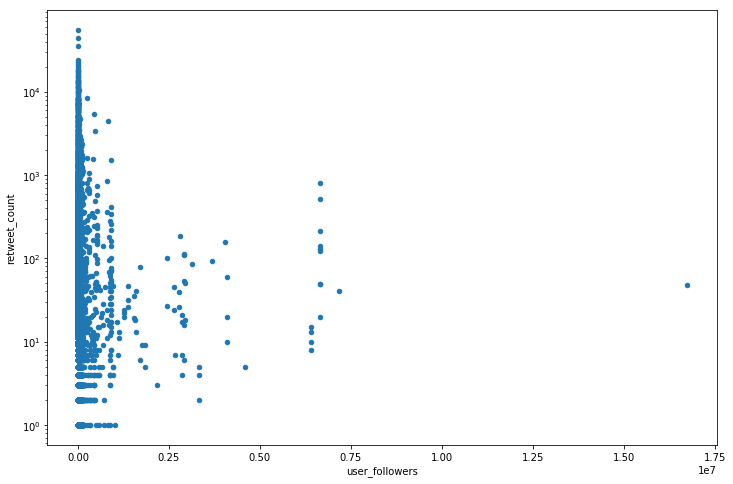

In [67]:
followers_and_retweets.plot.scatter(x='user_followers',y='retweet_count',figsize=(12,8)).set_yscale("log")

Most retweets are for people with few followers.

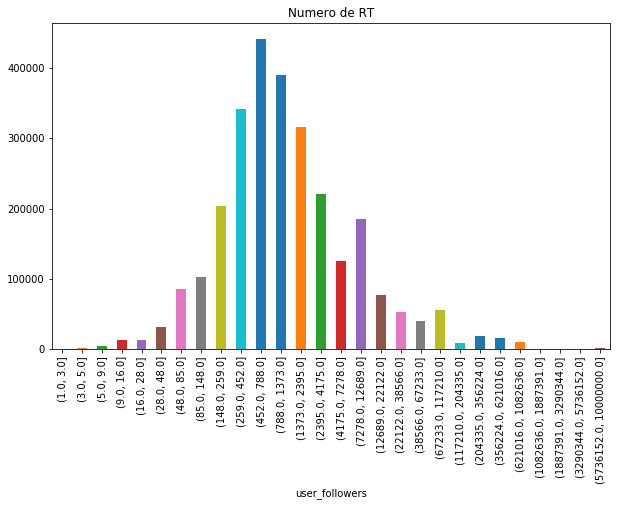

In [56]:
# partimos en rangos logaritmicos
divisiones=np.unique(np.floor(np.logspace(0,7, num=30)))
followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['retweet_count'].sum().plot.bar(figsize=(10,6),title='Numero de RT')

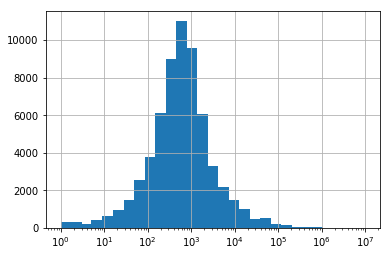

In [57]:
# Pero esto se parece a la cantidad de usuarios por bin!
followers_and_retweets['user_followers'].hist(bins=divisiones).set_xscale("log")

In [58]:
rt_count=followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['retweet_count'].sum()
user_count=followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['user_followers'].count()
follower_count=followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['user_followers'].sum()

In [59]:
agregados_por_rango=pd.DataFrame({"user_count":user_count,"retweet_count/40":rt_count/40, "followers": follower_count})
agregados_por_rango

,user_count,retweet_count/40,followers
user_followers,,,
"(1.0, 3.0]",270,19.250,648
"(3.0, 5.0]",238,33.525,1073
"(5.0, 9.0]",402,125.800,3010
"(9.0, 16.0]",611,323.800,7816
"(16.0, 28.0]",919,333.000,20497
"(28.0, 48.0]",1480,801.300,57163
"(48.0, 85.0]",2522,2145.500,169295
"(85.0, 148.0]",3805,2558.475,444376
"(148.0, 259.0]",6092,5084.125,1233049


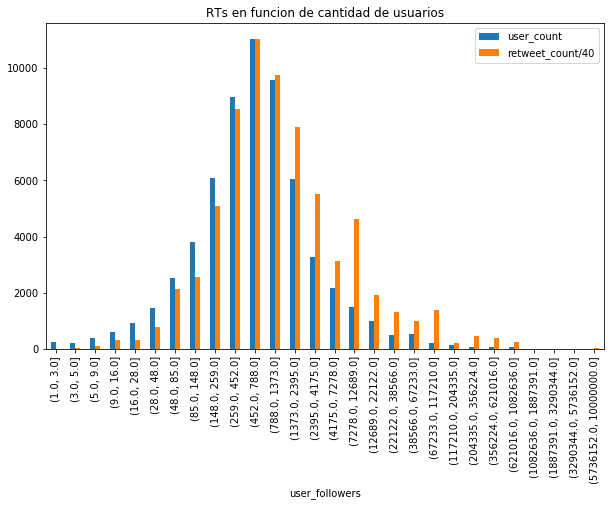

In [60]:
agregados_por_rango[["user_count","retweet_count/40"]].plot.bar(figsize=(10,6),title='RTs en funcion de cantidad de usuarios')

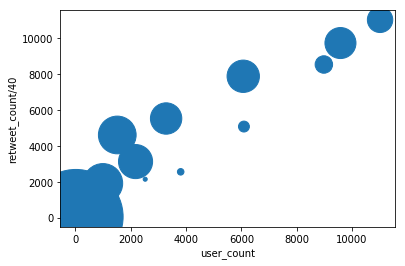

In [61]:
#creo que la cantidad de rt es que hay muchos usuarios
agregados_por_rango.plot.scatter(x="user_count",y="retweet_count/40",s=np.power(0.25*np.sqrt(follower_count/648),2))

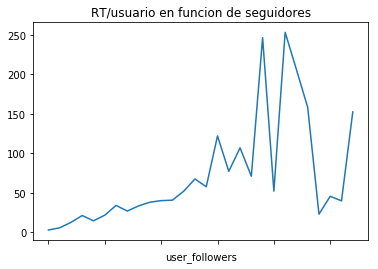

In [62]:
# en general nadie tiene un numero desproporcionado de RT 
(rt_count/user_count).plot(title="RT/usuario en funcion de seguidores")